## HW-3

### General Instructions: 
- Due Date: Wed Mar 4, 5 PM 
- Submission: Please work on this Notebook and leave it in your account on the server. We have a crontab job which will copy your submission Notebook from your account at sharp 5 PM on Wed, Mar 4. Any changes made to Notebook after 5 PM, Wed, Mar 4 will not be reflected in the submitted assignment. DO NOT change the name or location of this file on the server.
- __Plagiarism will not be tolerated in any form. Zero points will be awarded for the entire assignment in such cases__.

In [1]:
alias qstat /opt/pbs/bin/qstat -u $USER

In [2]:
qstat

In [46]:
import os, sys
import ase
import ase.calculators.vasp
import ase.io 
import ase.units
import ase.eos
from ase.visualize import view
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import mywrapper
pwd = os.getcwd()

### Pressure Driven Phase Transformation [80 points]

TiO$_2$ exists in many different structural phases such as Rutile, Anatase, Brookite, Hollandite, etc. Amongst others, the stability of these phases depends on the pressure and conditions. 

In this question, you are going to investigate the pressure driven phase change between Anatase and Rutile phases of TiO$_2$. 

One can determine pressure-driven phase transition by comparing enthalpies, `H`, of two phases. Enthalpy is defined as `H = E + PV`, where E is the internal/potential energy, and P, V are pressure and volume respectively.  The pressure is defined as $$P = -\frac{dE}{dV}$$ at const $T$ and enthalpy, $H$ is $$H = E + PV$$

You have to carry out the following steps:
- [10 points] Similar to formulation in HW1-Q4, write a function capable of calculating enthalpies and pressure given internal-energies and volumes
- [26 points] Anatase-Phase
  - [4 points] kgrid convergence [be sure that simulation cell size is/could be different in different directions]
  - [2 points] encut convergence
  - [2 points] sigma convergence
  - [6 points] structure relaxation using ISIF=3 
  - [12 points] Calculate enthalpy of Anatase phase as a function of pressure. For this you have to isotropically change the cell-volume and do only internal degrees relaxation using ISIF=4
 
- [26 points] Rutile-Phase
  - [4 points] kgrid convergence 
  - [2 points] encut convergence
  - [2 points] sigma convergence
  - [6 points] structure relaxation using ISIF=3 
  - [12 points] Calculate enthalpy of Rutile phase as a function of pressure. For this you have to isotropically change the cell-volume and do only internal degrees relaxation using ISIF=4
  
- [18 points] Plot enthalpies of Rutile and Anatase phases on the same plot and answer the following questions:
  - [4 points] plot of Enthalpies with Pressure [in GPa] with proper title, units, legend, etc.
  - [5 points] which phase is more stable at 0 Pressure?
  - [9 points] At what pressure phase transition happens from one of these phases to other [in GPa]? You may have to zoom-in on the pressure-axis to figure this out!
  
__Notes:__  
- __Use ediff of 1e-5 eV/atom in all calculations__
- __Relax all structures to 1e-3 eV/atom in all calculations__
- __Do convergence to within 1e-3 eV/atom for simulation parameters__

### Global parameters

In [47]:
ediff_natom = 1e-5
ediffg_natom = 1e-3
threshold_convergence_natom = 1e-3 

### Function to calculate enthalpies and pressure given energies and volumes 

In [48]:
def get_enthalpy_pressure(volumes, energies):
    '''
    Function takes list of volumes and list of energies as an input
    Function returns corresponding list of enthalpies and pressures
    '''
    enthalpies = []
    pressures = []
    c = np.polyfit(volumes, energies, 3)                # fitting curve between volume and energies
    Eq = np.poly1d(c)                                   
    P = -1*np.polyder(Eq)                               # differentiating polynimial equation w.r.t (v)
    for v,e in zip(volumes, energies):
        pressure = P(v)
        enthalpy = e + pressure*v                       # Enthalpy Values
        pressures.append(pressure/ase.units.GPa)
        enthalpies.append(enthalpy)
    
    return enthalpies, pressures

### Anatase

In [49]:
anatase = ase.io.read('anatase.cif')
anatase_cell = anatase.get_cell()
anatase_amag = []
# calculate lattice-vector magnitudes in amag; needed for kgrid later
#  amag[0] = sqrt(a1_x**2 + a1_y**2 + a1_z**2) and so on for amag[1] and amag[2]
for i in range(len(anatase_cell)):
    mag = np.sqrt(anatase_cell[i][0]**2+anatase_cell[i][1]**2+anatase_cell[i][2]**2)
    anatase_amag.append(mag)
    

#### kgrid convergence

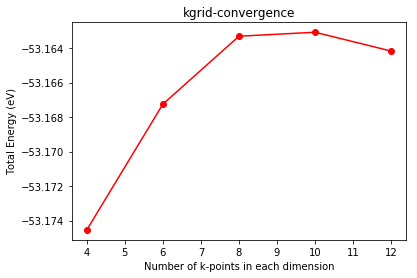

kpt | dE (meV/atom) | if converged?
----------------------------------------
  4          10.364     0
  6           3.077     1
  8           0.861     1
 10           1.091     1
 12           0.000     1


In [50]:
# make sure we are in the right path
os.chdir(pwd)

# normalize global variables by natom
ediff = ediff_natom * len(anatase)
ediffg = ediffg_natom * len(anatase)
threshold_convergence = threshold_convergence_natom * len(anatase)

# other simmulation parameetrs
XC = 'pbe'
encut = 350
sigma = 0.05
kpts = [4,6,8,10,12]     

# note that ANatase cell is not cubic! As such, a1, a2, and a3 are not equal and we need 
# to be careful to use different number of kpts in b1, b2, and b3 directions, so that 
# eventually the spacing between kpts in the reciprocal space, i.e. 
# the product of (amag[i] * kpts[i]),  is same in all three
# direction, where amag[i] is the length of lattice vector i and kpts[i] is the number of
# kpts in the ith direction

energies = []
for kpt in kpts:
    
    # get kpts in three directions
    kgrid = [kpt, int(round((kpt * anatase_amag[0])/anatase_amag[1])), 
                                int(round((kpt * anatase_amag[0])/anatase_amag[2]))]
    
    path = "TiO2/Anatase/kgrid/%d" % (kpt)                      # creating dir for kpts
    calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=kgrid,
            encut=350,
            ediff=ediff,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=0.05,
            lwave=False,   
            npar=2,  
            )
    anatase.set_calculator(calc)
    energy = mywrapper.get_energy(anatase, dir=path)  # getting energy for corresponding kpt and appending in the energies
    energies.append(energy)

plt.figure(0)
plt.plot(kpts, energies, 'ro-')
plt.xlabel('Number of k-points in each dimension')
plt.ylabel('Total Energy (eV)')
plt.title('kgrid-convergence')
plt.show()

# check convergence
energies = abs(np.array(energies) - energies[-1])
print("kpt | dE (meV/atom) | if converged?")
print('-'*40)
for kpt,e in zip(kpts, energies):
    print('%3d %15.3f %5d' % (kpt, 1000*e, e<threshold_convergence)) 

#### encut convergence

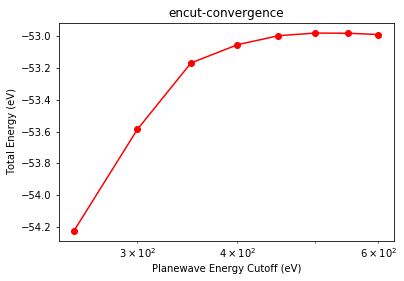

encut (eV) | dE (meV/atom) | if converged?
----------------------------------------
      250         205.870     0
      300          99.478     0
      350          29.817     0
      400          10.727     0
      450           1.277     0
      500           1.534     0
      550           1.296     0
      600           0.000     1


In [51]:
# make sure we are in the right path
os.chdir(pwd)
kpt = 6
encuts = [250,300,350,400,450,500,550,600]
energies = []
for encut in encuts:
    
    # dir-name for this encut calculation
    path = 'encut/%d' % (encut)
    
    # set basic calculator
    calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=[kpt, int(round((kpt * anatase_amag[0])/anatase_amag[1])), 
                                int(round((kpt * anatase_amag[0])/anatase_amag[2]))],
            encut=encut,
            ediff=ediff,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=0.05,
            lwave=False,            
            )
    
    anatase.set_calculator(calc)
    energy = mywrapper.get_energy(anatase, dir=path)
    energies.append(energy)
    
# plot between Planewave Energy Cutoff & Total Energy   
plt.figure(1)
plt.semilogx(encuts, energies, 'ro-')
plt.xlabel('Planewave Energy Cutoff (eV)')
plt.ylabel('Total Energy (eV)')
plt.title('encut-convergence')
plt.show()

# convert energies to meV/atom
natom = len(anatase.get_positions())

'''
[-2] why divide by natom here?
'''
energies = abs(1000*(np.array(energies) - energies[-1])/natom)
print("encut (eV) | dE (meV/atom) | if converged?")
print('-'*40)
for encut,e in zip(encuts, energies):
    print('%9d %15.3f %5d' % (encut, e, e<threshold_convergence))
    
'''
[-2]: seem sthat encut is not converged! should have increased the range!
'''

#### sigma convergence

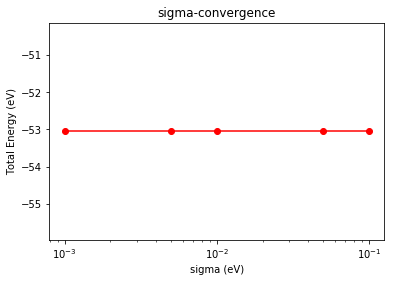

sigma (eV) | dE (meV/atom) | if converged?
----------------------------------------
    0.100           0.000     1
    0.050           0.000     1
    0.010           0.000     1
    0.005           0.000     1
    0.001           0.000     1


In [52]:
# make sure we are in the right path
os.chdir(pwd)


'''
[-2] why use 12x kpt here when 6x is converged?
'''
kpt = 12
sigmas = [0.10, 0.05, 0.01, 0.005, 0.001]
energies = []
for sigma in sigmas:
    
    # dir-name for this kpt calculation
    path = 'sigma/%d' % (int(1000*sigma))
    
    # set basic calculator
    calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=[kpt, int(round((kpt * anatase_amag[0])/anatase_amag[1])), 
                                int(round((kpt * anatase_amag[0])/anatase_amag[2]))],
        
        
            '''
            [-2] why use 400 encut?
            '''
            encut=400,
            ediff=ediff,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=sigma,
            lwave=False,
            )
    
    anatase.set_calculator(calc)
    energy = mywrapper.get_energy(anatase, dir=path)
    energies.append(energy)
# plot between sigma &  Total Energy
plt.figure(2)
plt.semilogx(sigmas, energies, 'ro-')
plt.xlabel('sigma (eV)')
plt.ylabel('Total Energy (eV)')
plt.title('sigma-convergence')
plt.show()    

# convert energies to meV/atom
natom = len(anatase.get_positions())
energies = abs(1000* (np.array(energies) - energies[-1])/natom)
print("sigma (eV) | dE (meV/atom) | if converged?")
print('-'*40)
for sigma,e in zip(sigmas, energies):
    print('%9.3f %15.3f %5d' % (sigma, e, e<threshold_convergence))

#### Structure relaxation

In [53]:
# make sure we are in the right path
os.chdir(pwd)
anatase_relax_path = 'structure_relax/vasp_relax/'
kpt = 6
energies = []
calc = ase.calculators.vasp.Vasp(
        xc="pbe",
        kpts=[kpt, int(round((kpt * anatase_amag[0])/anatase_amag[1])), 
                            int(round((kpt * anatase_amag[0])/anatase_amag[2]))],
        encut=encut,
        ediff=ediff,
        algo='fast',
        prec='accurate',
        nelmin=4,
        nelm=100,
        ismear=0,
        sigma=0.05,
        lwave=False, 
        nsw=100,
        ibrion=2,
        isif=3,
        ediffg=ediffg,  # criterion of 0.1 meV/atom change in energy 
        )
    
anatase.set_calculator(calc)
energy = mywrapper.get_energy(anatase, dir=anatase_relax_path)
calc = mywrapper.get_calculator(dir=anatase_relax_path)

if calc is not None:
    atoms = calc.atoms
    print('Stress-Tensor (GPa): ', calc.stress/ase.units.GPa)
    forces = calc.forces
    print('\nAtomic-Symbol | position (A) | force (eV/A)')
    print('-'*45)
    for i, atom in enumerate(atoms):
        print(atom.symbol, atom.position, forces[i])

    print("\nLattice-vectors:\n", atoms.get_cell())
    


Stress-Tensor (GPa):  [ 0.371642 -0.004666 -0.170895  0.        0.        0.300308]

Atomic-Symbol | position (A) | force (eV/A)
---------------------------------------------
Ti [ 4.25817865e+00  2.35701402e+00 -2.02450000e-12] [ 0. -0.  0.]
Ti [1.47596689 2.3584372  1.34863048] [ 0. -0.  0.]
O [3.23376615 3.33142538 1.34863048] [-0.016981 -0.0094    0.      ]
O [ 6.01597791e+00  3.33000220e+00 -2.85995486e-12] [-0.016981 -0.0094    0.      ]
O [-0.28183237  1.38544902  1.34863048] [ 0.016981  0.0094   -0.      ]
O [ 2.50037940e+00  1.38402584e+00 -1.18904514e-12] [ 0.016981  0.0094   -0.      ]

Lattice-vectors:
 [[ 5.56442352e+00 -2.84636806e-03 -2.02450000e-12]
 [ 2.95193379e+00  4.71687441e+00 -2.02450000e-12]
 [-4.25817866e+00 -2.35701402e+00  2.69726096e+00]]


#### Isotropic volume change and pressure calculation

[[ 5.56442352e+00 -2.84636806e-03 -2.02450000e-12]
 [ 2.95193379e+00  4.71687441e+00 -2.02450000e-12]
 [-4.25817866e+00 -2.35701402e+00  2.69726096e+00]]


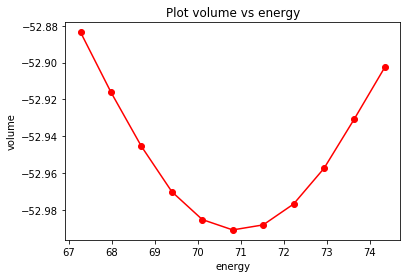

In [54]:
# make sure we are in the right path
os.chdir(pwd)
path = 'structure_relax/vasp_relax/'
# volumes to scale by
scales = [0.95,0.96,0.97,0.98,0.99,1.0,1.01,1.02,1.03,1.04,1.05]
# read the relaxed anatase structure and isotropically change the volume
###calc = mywrapper.get_calculator(dir=anatase_relax_path)
calc = mywrapper.get_calculator(dir=path)
if calc is not None:
    volumes = []
    energies = []

    atoms = calc.atoms
    cell = np.array(atoms.get_cell())
    print(cell)
    natom = len(atoms)
    for scale in scales:
        atoms.set_cell(cell*((scale)**(1/3)))
        volumes.append(atoms.get_volume())
        path="TiO2/Anatase_2/E_1/%f" %(scale)
        cal = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=kgrid,
            encut=encut,
            ediff=ediff,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=sigma,
            lwave=False,
            npar=4,
 # following are new relaxation-related parameets
            nsw=100,
            ibrion=2,
            isif=4,
            ediffg=ediffg, # criterion of 0.1 meV/atom change in energy
        )
        atoms.set_calculator(cal)
        energies.append(mywrapper.get_energy(atoms, dir=path))
plt.plot(volumes,energies,'ro-')
plt.title("Plot volume vs energy")
plt.xlabel("energy")
plt.ylabel("volume")
plt.show()

In [55]:
qstat

#### get enthapies and pressure

In [56]:
anatase_h, anatase_p = get_enthalpy_pressure(volumes, energies)

In [58]:
anatase_p

[9.393596591802526,
 7.581594541822208,
 5.776180901457808,
 3.977355670710039,
 2.1851188495784015,
 0.3994704380632514,
 -1.3795895638357667,
 -3.1520611561182617,
 -4.917944338784554,
 -6.677239111834393,
 -8.429945475267994]

### Now repeat for Rutile

In [59]:
rutile = ase.io.read('rutile.cif')
rutile_cell = rutile.get_cell()
rutile_amag = []
# calculate lattice-vector magnitudes in amag; needed for kgrid later
#  amag[0] = sqrt(a1_x**2 + a1_y**2 + a1_z**2) and so on for amag[1] and amag[2]
for i in range(len(rutile_cell)):
    mag = np.sqrt(rutile_cell[i][0]**2+rutile_cell[i][1]**2+rutile_cell[i][2]**2)
    rutile_amag.append(mag)
    
print(rutile_amag)


[4.60677734, 4.60677734, 2.99175662]


#### kgrid-convergence

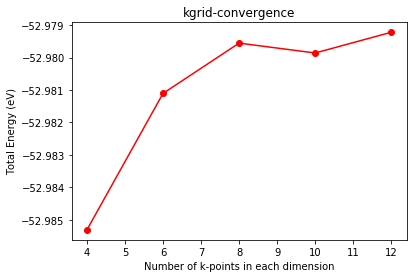

kpt | dE (meV/atom) | if converged?
----------------------------------------
  4           6.100     0
  6           1.888     1
  8           0.336     1
 10           0.640     1
 12           0.000     1


In [60]:
# make sure we are in the right path
os.chdir(pwd)

# normalize global variables by natom
ediff = ediff_natom * len(rutile)
ediffg = ediffg_natom * len(rutile)
threshold_convergence = threshold_convergence_natom * len(rutile)

kpts = [4,6,8,10,12]     

# note that Rutile cell is not cubic! As such, a1, a2, and a3 are not equal and we need 
# to be careful to use different number of kpts in b1, b2, and b3 directions, so that 
# eventually the spacing between kpts in the reciprocal space, i.e. 
# the product of (amag[i] * kpts[i]),  is same in all three
# direction, where amag[i] is the length of lattice vector i and kpts[i] is the number of
# kpts in the ith direction

energies = []
for kpt in kpts:
    
    # get kpts in three directions
    kgrid = [kpt, int(round((kpt * rutile_amag[0])/rutile_amag[1])), 
                                int(round((kpt * rutile_amag[0])/rutile_amag[2]))]
    
    path = "TiO2/rutile/kgrid/%d" % (kpt)
    calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=kgrid,
            encut=350,
            ediff=ediff,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=0.05,
            lwave=False,   
            npar=2,  
            )
    rutile.set_calculator(calc)
    energy = mywrapper.get_energy(rutile, dir=path)
    energies.append(energy)

plt.figure(0)
plt.plot(kpts, energies, 'ro-')
plt.xlabel('Number of k-points in each dimension')
plt.ylabel('Total Energy (eV)')
plt.title('kgrid-convergence')
plt.show()

# check convergence
energies = abs(np.array(energies) - energies[-1])
print("kpt | dE (meV/atom) | if converged?")
print('-'*40)
for kpt,e in zip(kpts, energies):
    print('%3d %15.3f %5d' % (kpt, 1000*e, e<threshold_convergence)) 


#### encut convergence

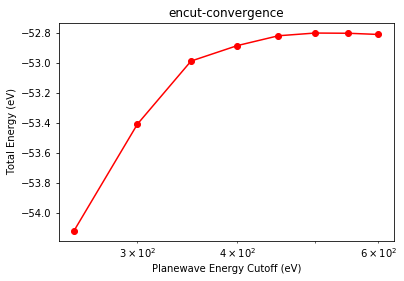

encut (eV) | dE (meV/atom) | if converged?
----------------------------------------
      250         218.533     0
      300          99.847     0
      350          29.649     0
      400          12.369     0
      450           1.469     0
      500           1.566     0
      550           1.322     0
      600           0.000     1


In [61]:
# make sure we are in the right path
os.chdir(pwd)

encuts = [250,300,350,400,450,500,550,600]
energies = []

for encut in encuts:
    
    # dir-name for this encut calculation
    path = 'TiO2/rutile/encut_r/%d' % (encut)
    
    # set basic calculator
    calc = ase.calculators.vasp.Vasp(
            xc="pbe",
        
            '''
            [-2] did not initialize kpt!
            '''
            kpts=[kpt, int(round((kpt * rutile_amag[0])/rutile_amag[1])), 
                                int(round((kpt * rutile_amag[0])/rutile_amag[2]))],
            encut=encut,
            ediff=ediff,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=0.05,
            lwave=False,            
            )
    
    rutile.set_calculator(calc)
    energy = mywrapper.get_energy(rutile, dir=path)
    energies.append(energy)
    
    
plt.figure(1)
plt.semilogx(encuts, energies, 'ro-')
plt.xlabel('Planewave Energy Cutoff (eV)')
plt.ylabel('Total Energy (eV)')
plt.title('encut-convergence')
plt.show()

# convert energies to meV/atom
natom = len(rutile.get_positions())
energies = abs(1000*(np.array(energies) - energies[-1])/natom)
print("encut (eV) | dE (meV/atom) | if converged?")
print('-'*40)
for encut,e in zip(encuts, energies):
    print('%9d %15.3f %5d' % (encut, e, e<threshold_convergence))
    
'''
[-2]: seem sthat encut is not converged! should have increased the range!
'''

#### sigma convergence

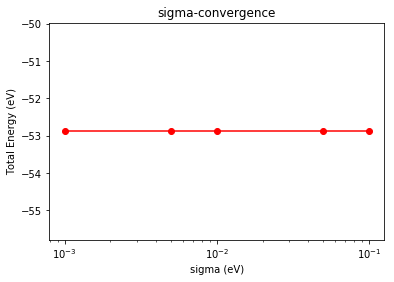

sigma (eV) | dE (meV/atom) | if converged?
----------------------------------------
    0.100           0.000     1
    0.050           0.000     1
    0.010           0.000     1
    0.005           0.000     1
    0.001           0.000     1


In [62]:
# make sure we are in the right path
os.chdir(pwd)

sigmas = [0.10, 0.05, 0.01, 0.005, 0.001]
energies = []

for sigma in sigmas:
    
    # dir-name for this kpt calculation
    path = 'TiO2/rutile/sigma_r/%d' % (int(1000*sigma))
    
    # set basic calculator
    calc = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=[kpt, int(round((kpt * rutile_amag[0])/rutile_amag[1])), 
                                int(round((kpt * rutile_amag[0])/rutile_amag[2]))],
            encut=500,
            ediff=ediff,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=sigma,
            lwave=False,
            )
    
    rutile.set_calculator(calc)
    energy = mywrapper.get_energy(rutile, dir=path)
    energies.append(energy)
    
plt.figure(2)
plt.semilogx(sigmas, energies, 'ro-')
plt.xlabel('sigma (eV)')
plt.ylabel('Total Energy (eV)')
plt.title('sigma-convergence')
plt.show()    

# convert energies to meV/atom
natom = len(rutile.get_positions())
energies = abs(1000* (np.array(energies) - energies[-1])/natom)
print("sigma (eV) | dE (meV/atom) | if converged?")
print('-'*40)
for sigma,e in zip(sigmas, energies):
    print('%9.3f %15.3f %5d' % (sigma, e, e<threshold_convergence))

#### structure relaxation

In [63]:
# make sure we are in the right path
os.chdir(pwd)
rutile_relax_path = 'structure_relax_rutile/vasp_relax/'

energies = []
calc = ase.calculators.vasp.Vasp(
        xc="pbe",
        kpts=[kpt, int(round((kpt * rutile_amag[0])/rutile_amag[1])), 
                            int(round((kpt * rutile_amag[0])/rutile_amag[2]))],
        encut=encut,
        ediff=ediff,
        algo='fast',
        prec='accurate',
        nelmin=4,
        nelm=100,
        ismear=0,
        sigma=0.05,
        lwave=False, 
        nsw=100,
        ibrion=2,
        isif=3,
        ediffg=ediffg,  # criterion of 0.1 meV/atom change in energy 
        )
    
rutile.set_calculator(calc)
energy = mywrapper.get_energy(rutile, dir=rutile_relax_path)
calc = mywrapper.get_calculator(dir=rutile_relax_path)

if calc is not None:
    atoms = calc.atoms
    print('Stress-Tensor (GPa): ', calc.stress/ase.units.GPa)
    forces = calc.forces
    print('\nAtomic-Symbol | position (A) | force (eV/A)')
    print('-'*45)
    for i, atom in enumerate(atoms):
        print(atom.symbol, atom.position, forces[i])

    print("\nLattice-vectors:\n", atoms.get_cell())
    

Stress-Tensor (GPa):  [ 0.008584  0.008584 -0.041211 -0.       -0.       -0.      ]

Atomic-Symbol | position (A) | force (eV/A)
---------------------------------------------
Ti [0. 0. 0.] [ 0. -0. -0.]
Ti [2.33071374 2.33071374 1.48405024] [ 0. -0. -0.]
O [3.24147276 3.24147276 0.        ] [-0.002 -0.002 -0.   ]
O [1.41995472 1.41995472 0.        ] [0.002 0.002 0.   ]
O [0.91075902 3.75066846 1.48405024] [-0.002  0.002  0.   ]
O [3.75066846 0.91075902 1.48405024] [ 0.002 -0.002 -0.   ]

Lattice-vectors:
 [[ 4.66142748 -0.          0.        ]
 [-0.          4.66142748  0.        ]
 [ 0.          0.          2.96810047]]


#### isotropic volume change and pressure calculation

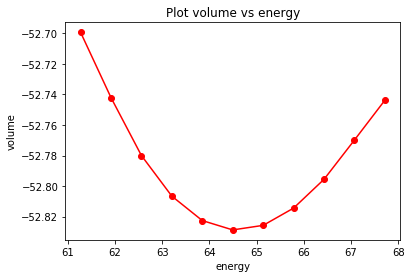

In [64]:
# make sure we are in the right path
os.chdir(pwd)
rutile_relax_path = 'structure_relax_rutile/vasp_relax/'

# volumes to scale by
scales = [0.95,0.96,0.97,0.98,0.99,1.0,1.01,1.02,1.03,1.04,1.05]

# read the relaxed anatase structure and isotropically change the volume
calc = mywrapper.get_calculator(dir=rutile_relax_path)
if calc is not None:
    volumes = []
    energies = []
    
    atoms = calc.atoms
    cell = np.array(atoms.get_cell())
    natom = len(atoms)
    
    for scale in scales:
        atoms.set_cell(cell*((scale)**(1/3)))
        volumes.append(atoms.get_volume())
        path="TiO2/Rutile_2/E_1/%f" %(scale)
        cal = ase.calculators.vasp.Vasp(
            xc="pbe",
            kpts=[kpt, int(round((kpt * rutile_amag[0])/rutile_amag[1])), 
                                int(round((kpt * rutile_amag[0])/rutile_amag[2]))],
            encut=encut,
            ediff=ediff,
            algo='fast',
            prec='accurate',
            nelmin=4,
            nelm=100,
            ismear=0,
            sigma=sigma,
            lwave=False,
            npar=4, 
            nsw=100,
            ibrion=2,
            isif=4,
            ediffg=ediffg,
        )
        atoms.set_calculator(cal)
        energies.append(mywrapper.get_energy(atoms, dir=path))
plt.plot(volumes,energies,'ro-')
plt.title("Plot volume vs energy")
plt.xlabel("energy")
plt.ylabel("volume")
plt.show() 


In [66]:
rutile_h, rutile_p = get_enthalpy_pressure(volumes, energies)


In [67]:
rutile_h

[-47.61542602081062,
 -48.73710066067038,
 -49.80950865978356,
 -50.824058524304,
 -51.77933027038551,
 -52.67400046418191,
 -53.506720891846975,
 -54.27616959953457,
 -54.981008663398484,
 -55.61981021959257,
 -56.19702228427068]

In [68]:
 rutile_p

[13.294181827131277,
 10.363772226357975,
 7.607577050095338,
 5.025596298343365,
 2.617829971102057,
 0.3842780683714135,
 -1.6750594098484228,
 -3.5601824635575947,
 -5.271091092755959,
 -6.807785297443659,
 -8.170265077620694]

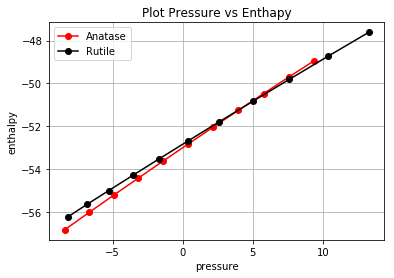

In [69]:
# plot now
plt.figure(0)
plt.plot(anatase_p,anatase_h,'ro-',rutile_p,rutile_h,'ko-')
plt.title("Plot Pressure vs Enthapy")
plt.xlabel("pressure")
plt.ylabel("enthalpy")
plt.legend(['Anatase','Rutile'])
plt.grid()
plt.show()

'''
[-4] units of x/y axis?
'''

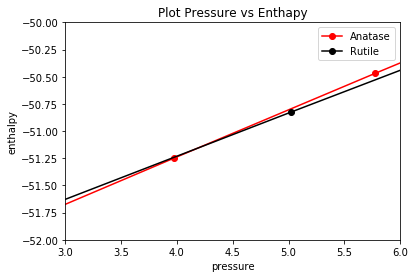

In [86]:
# zoom-in
plt.figure(1)
plt.plot(anatase_p,anatase_h,'ro-',rutile_p,rutile_h,'ko-')
plt.title("Plot Pressure vs Enthapy")
plt.xlabel("pressure")
plt.ylabel("enthalpy")
plt.legend(['Anatase','Rutile'])
plt.ylim([-52,-50])
plt.xlim([3,6])
plt.show()

In [1]:
print('Anatase is more stable at pressure=0')
print("Phase change occured at pressure = 4 Gpa")

Anatase is more stable at pressure=0
Phase change occured at pressure = 4 Gpa


In [ ]:
Total: -14